Connected to base (Python 3.10.13)

In [1]:
##################################################
# Introduction to Text Mining and Natural Language Processing
##################################################

##################################################
# Sentiment Analysis and Sentiment Modeling for Amazon Reviews
##################################################

# 1. Text Preprocessing
# 2. Text Visualization
# 3. Sentiment Analysis
# 4. Feature Engineering
# 5. Sentiment Modeling

# !pip install nltk
# !pip install textblob
# !pip install wordcloud


from warnings import filterwarnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
from sklearn.preprocessing import LabelEncoder
from textblob import Word, TextBlob
from wordcloud import WordCloud

filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

##################################################
# 1. Text Preprocessing
##################################################

df = pd.read_csv("./source/datasets/amazon_reviews.csv", sep=",")
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",No issues.,4.00,Four Stars,1406073600,2014-07-23,138,0,0
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]","Purchased this for my device, it worked as adv...",5.00,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",it works as expected. I should have sprung for...,4.00,nothing to really say....,1356220800,2012-12-23,715,0,0
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",This think has worked out great.Had a diff. br...,5.00,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]","Bought it with Retail Packaging, arrived legit...",5.00,best deal around,1373673600,2013-07-13,513,0,0


In [2]:
###############################
# Normalizing Case Folding
###############################

df['reviewText'] = df['reviewText'].str.lower()

In [3]:
###############################
# Punctuations
###############################

df['reviewText'] = df['reviewText'].str.replace('[^\w\s]', '')

In [4]:
###############################
# Numbers
###############################

df['reviewText'] = df['reviewText'].str.replace('\d', '')

In [5]:
###############################
# Stopwords
###############################
import nltk
# nltk.download('stopwords')

sw = stopwords.words('english')

df['reviewText'] = df['reviewText'].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))

In [6]:
###############################
# Rarewords
###############################

temp_df = pd.Series(' '.join(df['reviewText']).split()).value_counts()

drops = temp_df[temp_df <= 1]

df['reviewText'] = df['reviewText'].apply(lambda x: " ".join(x for x in x.split() if x not in drops))

In [7]:
###############################
# Tokenization
###############################

# nltk.download("punkt")

df["reviewText"].apply(lambda x: TextBlob(x).words).head()

0                                             [issues]
1    [purchased, device, worked, advertised, never,...
2    [works, expected, higher, capacity, think, mad...
3    [think, worked, gb, card, went, south, one, he...
4    [bought, retail, packaging, arrived, legit, en...
Name: reviewText, dtype: object

In [8]:
###############################
# Lemmatization
###############################

# nltk.download('wordnet')
df['reviewText'] = df['reviewText'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

In [9]:
##################################################
# 2. Text Visualization
##################################################


###############################
# Terim Frekanslarının Hesaplanması
###############################

tf = df["reviewText"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()

tf.columns = ["words", "tf"]

tf.sort_values("tf", ascending=False)

,words,tf
27,card,5537.00
14,work,2044.00
7,phone,1909.00
39,gb,1756.00
98,great,1445.00
...,...,...
2721,sizethe,2.00
2719,everybody,2.00
2717,lived,2.00
3687,chkdsk,2.00


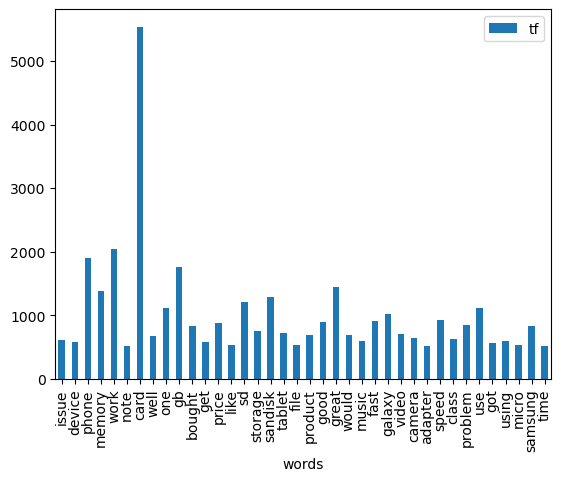

In [10]:
###############################
# Barplot
###############################

tf[tf["tf"] > 500].plot.bar(x="words", y="tf")
plt.show()

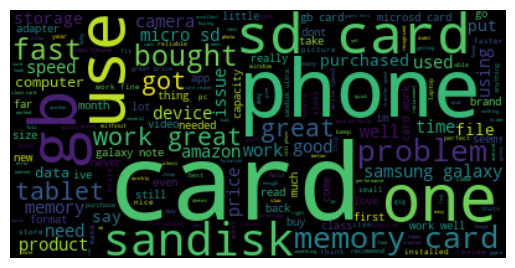

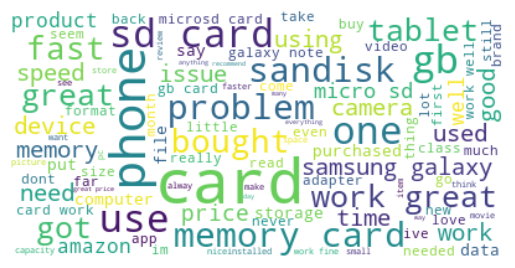

In [11]:
###############################
# Wordcloud
###############################

text = " ".join(i for i in df.reviewText)

wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


wordcloud = WordCloud(max_font_size=50,
                      max_words=100,
                      background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

wordcloud.to_file("wordcloud.png")

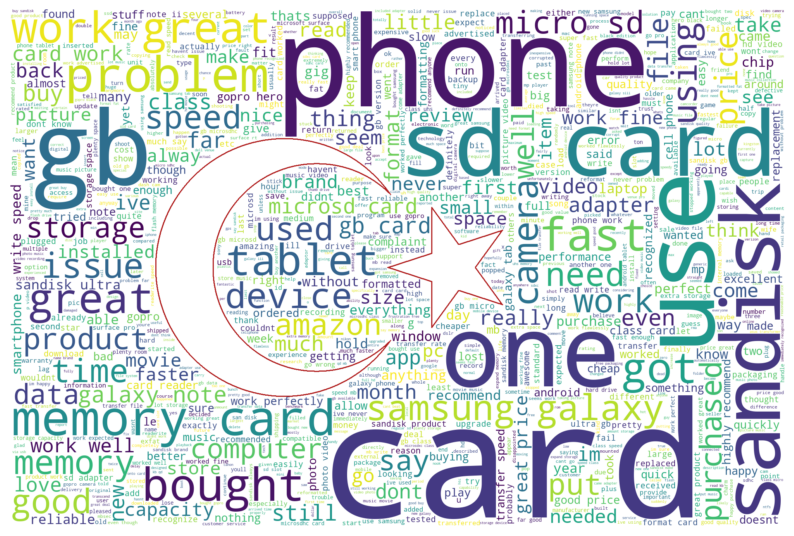

In [12]:
###############################
# Şablonlara Göre Wordcloud
###############################

tr_mask = np.array(Image.open("tr.png"))

wc = WordCloud(background_color="white",
               max_words=1000,
               mask=tr_mask,
               contour_width=3,
               contour_color="firebrick")

wc.generate(text)
plt.figure(figsize=[10, 10])
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [13]:
##################################################
# 3. Sentiment Analysis
##################################################

df["reviewText"].head()

# nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()
sia.polarity_scores("The film was awesome")


sia.polarity_scores("I liked this music but it is not good as the other one")


df["reviewText"][0:10].apply(lambda x: sia.polarity_scores(x))

df["reviewText"][0:10].apply(lambda x: sia.polarity_scores(x)["compound"])

df["polarity_score"] = df["reviewText"].apply(lambda x: sia.polarity_scores(x)["compound"])

In [14]:
###############################
# 4. Feature Engineering
###############################

df["reviewText"][0:10].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")

df["sentiment_label"] = df["reviewText"].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")

df["sentiment_label"].value_counts()

df.groupby("sentiment_label")["overall"].mean()

df["sentiment_label"] = LabelEncoder().fit_transform(df["sentiment_label"])

y = df["sentiment_label"]
X = df["reviewText"]

In [15]:
###############################
# Count Vectors
###############################

# Count Vectors: frekans temsiller
# TF-IDF Vectors: normalize edilmiş frekans temsiller
# Word Embeddings (Word2Vec, GloVe, BERT vs)


# words
# kelimelerin nümerik temsilleri

# characters
# karakterlerin numerik temsilleri

# ngram
a = """Bu örneği anlaşılabilmesi için daha uzun bir metin üzerinden göstereceğim.
N-gram'lar birlikte kullanılan kelimelerin kombinasyolarını gösterir ve feature üretmek için kullanılır"""

TextBlob(a).ngrams(3)

[WordList(['Bu', 'örneği', 'anlaşılabilmesi']),
 WordList(['örneği', 'anlaşılabilmesi', 'için']),
 WordList(['anlaşılabilmesi', 'için', 'daha']),
 WordList(['için', 'daha', 'uzun']),
 WordList(['daha', 'uzun', 'bir']),
 WordList(['uzun', 'bir', 'metin']),
 WordList(['bir', 'metin', 'üzerinden']),
 WordList(['metin', 'üzerinden', 'göstereceğim']),
 WordList(['üzerinden', 'göstereceğim', "N-gram'lar"]),
 WordList(['göstereceğim', "N-gram'lar", 'birlikte']),
 WordList(["N-gram'lar", 'birlikte', 'kullanılan']),
 WordList(['birlikte', 'kullanılan', 'kelimelerin']),
 WordList(['kullanılan', 'kelimelerin', 'kombinasyolarını']),
 WordList(['kelimelerin', 'kombinasyolarını', 'gösterir']),
 WordList(['kombinasyolarını', 'gösterir', 've']),
 WordList(['gösterir', 've', 'feature']),
 WordList(['ve', 'feature', 'üretmek']),
 WordList(['feature', 'üretmek', 'için']),
 WordList(['üretmek', 'için', 'kullanılır'])]

In [20]:
###############################
# Count Vectors
###############################

from sklearn.feature_extraction.text import CountVectorizer

corpus = [
    "This is the first document.",
    "This document is the second document.",
    "And this is the third one.",
    "Is this the first document?",
]

# word frekans
vectorizer2 = CountVectorizer()
X_c = vectorizer2.fit_transform(corpus)
print(vectorizer2.get_feature_names_out())
print(X_c.toarray())

# n-gram frekans
vectorizer2 = CountVectorizer(analyzer="word", ngram_range=(2, 2))
X_n = vectorizer2.fit_transform(corpus)
print(vectorizer2.get_feature_names_out())
print(X_n.toarray())

# Here, you're trying to fit_transform on X which is not defined in your code.
# I assume you wanted to use 'corpus' instead of 'X'.
vectorizer = CountVectorizer()
X_count = vectorizer.fit_transform(corpus)

print(vectorizer.get_feature_names_out()[10:15])
print(X_count.toarray()[10:15])

['and' 'document' 'first' 'is' 'one' 'second' 'the' 'third' 'this']
[[0 1 1 1 0 0 1 0 1]
 [0 2 0 1 0 1 1 0 1]
 [1 0 0 1 1 0 1 1 1]
 [0 1 1 1 0 0 1 0 1]]
['and this' 'document is' 'first document' 'is the' 'is this'
 'second document' 'the first' 'the second' 'the third' 'third one'
 'this document' 'this is' 'this the']
[[0 0 1 1 0 0 1 0 0 0 0 1 0]
 [0 1 0 1 0 1 0 1 0 0 1 0 0]
 [1 0 0 1 0 0 0 0 1 1 0 1 0]
 [0 0 1 0 1 0 1 0 0 0 0 0 1]]
[]
[]


In [21]:
###############################
# TF-IDF
###############################

from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf_word_vectorizer = TfidfVectorizer()
X_tf_idf_word = tf_idf_word_vectorizer.fit_transform(X)


tf_idf_ngram_vectorizer = TfidfVectorizer(ngram_range=(2, 3))
X_tf_idf_ngram = tf_idf_ngram_vectorizer.fit_transform(X)

In [22]:
###############################
# 5. Sentiment Modeling
###############################

# 1. Text Preprocessing
# 2. Text Visualization
# 3. Sentiment Analysis
# 4. Feature Engineering
# 5. Sentiment Modeling

###############################
# Logistic Regression
###############################

log_model = LogisticRegression().fit(X_tf_idf_word, y)

cross_val_score(log_model, X_tf_idf_word, y, scoring="accuracy", cv=5).mean()


new_review = pd.Series("this product is great")
new_review = pd.Series("look at that shit very bad")
new_review = pd.Series("it was good but I am sure that it fits me")

new_review = TfidfVectorizer().fit(X).transform(new_review)

log_model.predict(new_review)

random_review = pd.Series(df["reviewText"].sample(1).values)

new_review = TfidfVectorizer().fit(X).transform(random_review)

log_model.predict(new_review)

array([1])

In [23]:
###############################
# Random Forests
###############################